# Automated load and dump detection for trucks with Light Gradient-Boosting Machine (LightGBM)

This notebook showcases the application of an automated algorithm for detecting loading and dumping events. LightGBM is employed, a highly efficient state-of-the-art gradient boosting framework that uses decision trees as weak learners. Additional insights into the methodology can be found in [Website Link] and [LaTeX Document].

# Required folder and data structure

The required folder structure, where 'data' folder is top level:

<pre>
data/                  <-- This is the top-level directory
└── GPSData/           <-- This is the second-level directory
    ├── trips/         <-- These are third-level directories
    └── tripInfo/      <-- These are third-level directories
</pre>


Folder 'trips' and 'tripsInfo' should contain GPS files on form MM-DD-YYYY.csv with columns:
* **trips**: TripLogId, Timestamp, Latitude, Longitude, Uncertainty
* **tripsInfo**: TripLogId, DumperMachineNumber/DumperMachineName, MachineType, LoadLongitude, LoadLatitude, DumpLongitude, DumpLatitude, MassTypeMaterial, Quantity 

# Initialize model

The custom machine learning class created for this project, LoadDumpLightGBM, utilizes functions in folder: **helper_functions** and in **load_dump_lightgbm.py**. LoadDumpLightGBM accepts the following initial (excluding directory) arguments:

* *group_size*: Defines the number of data points to be aggregated in the GPS dataset. A larger *group_size* results in a broader time window, enhancing the model's predictive accuracy for loading or dumping events within that timeframe. However, this comes at the cost of temporal precision regarding when these events occur.

* *nb_days*: Specifies the number of days to be analyzed. The option 'all' is available for those wishing to leverage their entire dataset. While utilizing more days is likely to improve predictive performance, it will also increase both data-loading and model-training time. The training time increases approximately linearly with *nb_days*.

* *starting_from*: Index to start from. A value of 0 implies all days in *nb_days* are employed.

In [1]:
# automatically reload if changes are done in any module
%load_ext autoreload
%autoreload 2

In [2]:
GPS_DATA_DIRECTORY = "data/GPSData"

In [18]:
from load_dump_lightgbm import LoadDumpLightGBM
myModel = LoadDumpLightGBM(nb_days="all", gps_data_dir=GPS_DATA_DIRECTORY, machine_type="Truck")  

Folders 'trips' and 'tripsInfo' correctly set up
Initializing class:
----------------------
Data over:  all days.
Merging  5  consecutive timestamps
Model applies on machine type: Truck
All data will be saved to the automatically created path:  data/ml_model_data


# Load GPS data and construct data set
The GPS data is loaded and processed to generate the features and output labels used in the machine learning algorithm. This is a time consuming process and loading and converting the complete data set in data/GPSData may take up to 2 hours. Employing all available GPS data results in a created data set of more than one million timestamps. For further development, it is recommended to store this file in a cloud-based storage. The data is divided into two sets: training data and unseen testing data. Each of these datasets is saved in its own unique folder within the data/ml_model_data directory. Folders are uniquely named based on the nb_days parameter, allowing for easy identification and retrieval. The naming convention for the test and training datasets follows this format: 
* Testing data: my_test_from_class_'nb_days'_days 
* Training data: my_train_from_class_'nb_days'_days.

In [4]:
myModel.load_data()

Start at day  03-07-2022
For machine type:  Truck


  0%|          | 0/73 [00:00<?, ?it/s]

100%|██████████| 73/73 [1:49:40<00:00, 90.14s/it] 


# Fit model to training data
Before initiating the training process, the training data is partitioned into two subsets: a training set and a validation set, which comprise 80% and 20% of the data, respectively. The validation set serves a critical role in assessing the model's generalization performance, aiding in the identification of both underfitting and overfitting scenarios.

The training process is designed to terminate automatically based on a predefined early-stopping criterion. Specifically, the model stops training when the validation error fails to improve over a given number of *n* iterations. This approach ensures computational efficiency while guarding against overfitting. Setting the early stopping criteria too low could compromise model performance, making it vulnerable to premature termination due to fluctuating error gradients. Conversely, a number too high enhances the risk of overfitting to training data. To run the model on the same data set while adjusting early stopping criteria and number of iterations, change the attributes of class *CustomLightgbmParams* found in **load_dump_lightgbm.py**. There is no need to use the *load_data* method again; simply reinitialize *myModel* as outlined above.

Upon reaching the early-stopping condition, the *fit_model* method outputs relevant diagnostic information. This includes the specified early-stopping criterion, as well as the iteration where the validation error was minimized. Performance metrics for both the training and validation sets are reported in terms of multi-logloss, providing a comprehensive view of the model's efficacy.

In [19]:
myModel.fit_model()

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2554]	Train's multi_logloss: 0.000697267	Val's multi_logloss: 0.0230563


# Learning curve
The model's learning curve can be visualized using the *plot_learning_curve* method. This curve plots the multi-logloss metric against the number of iterations, offering insights into the model's learning process over time. The graph presents both training and validation errors, allowing for a nuanced understanding of the model's performance. Notably, the y-axis is set on a logarithmic scale, which helps in capturing the nuances of error reduction across iterations more effectively. The observed error gradient is notably negative in early iterations, leveling off to approach zero with increasing iterations. In contrast, the training gradient tends to stabilize over an extended number of iterations. These patterns emphasize the need for early stopping criteria to mitigate the risk of overfitting the training data.

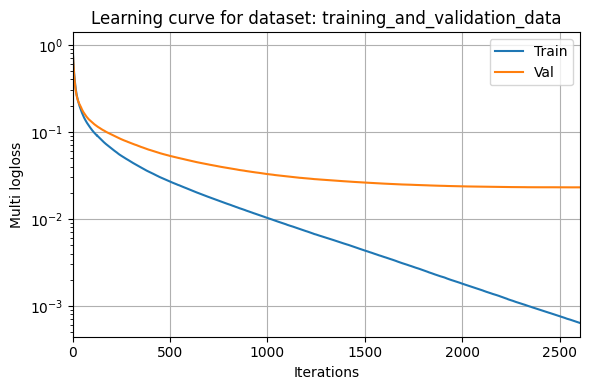

In [20]:
myModel.plot_learning_curve()

# Feature importances
The *plot_feature_importances* method visualizes the significance of each feature used during the training process. On the x-axis, the numerical values indicate the frequency with which a particular feature is employed to partition nodes in the decision trees. Essentially, features that contribute the most to information gain, or have the most negative impact on the error gradient, are used more frequently for splitting. A higher number on the x-axis thus corresponds to greater feature importance in the model's decision-making process.

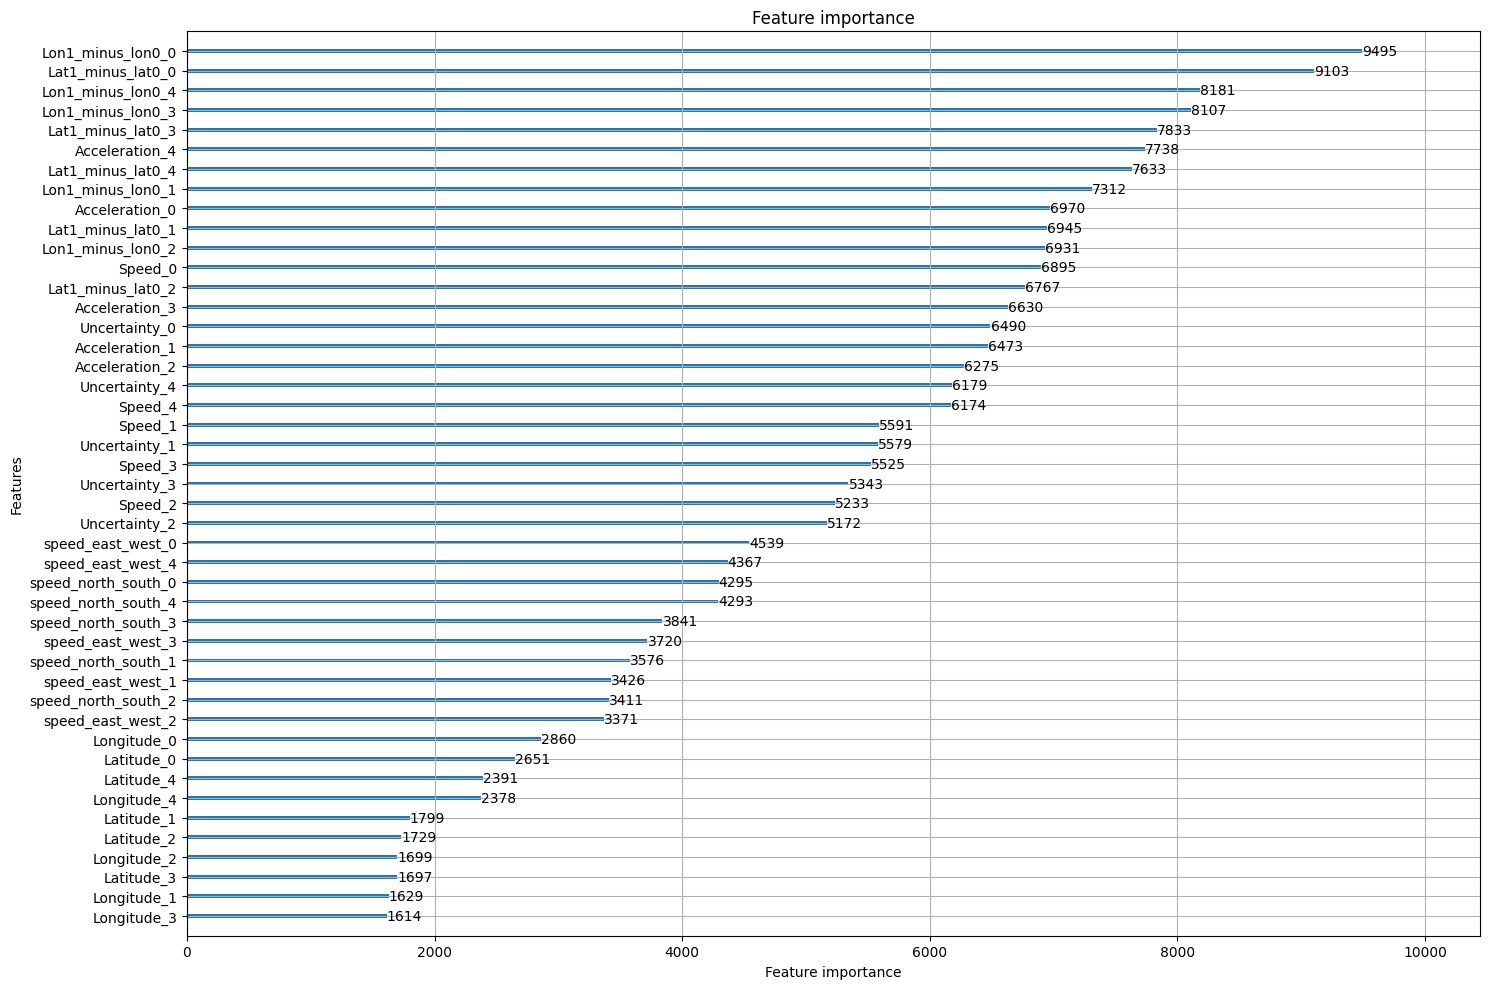

In [21]:
myModel.plot_feature_importances()

# Predict unseen data
The *predict_and_save_csv* method is responsible for generating predicted output labels, either "Driving," "Dump," or "Load", for the test dataset. This test dataset is located within the data/ml_model_data directory and is stored in a folder corresponding to the specific day under analysis. The method not only performs the predictions but also saves the results in a CSV file for easy access and further evaluation. Be aware that the size of this file can grow substantially, increasing in a fairly linear fashion with the number of days being analyzed.

In [22]:
myModel.predict_and_save_csv()

# Statistics
The *plot_statistics* method visualizes key classification metrics - precision, recall, and F1-score - for each output label using a heatmap. This approach provides an intuitive and easily interpretable overview of the model's performance across different classes.

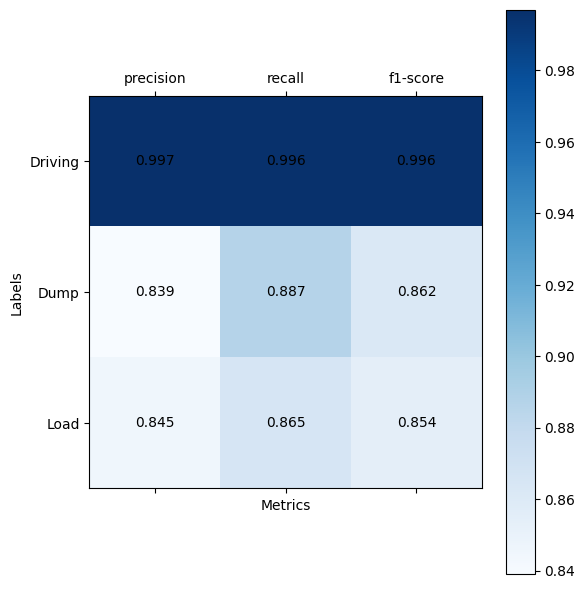

In [23]:
myModel.plot_statistics()

# Confusion matrix
The *plot_confusion_matrix* method visualizes the relationship between true and predicted labels using a heatmap format. The diagonal entries, starting from the top-left corner, represent correct classifications and ideally should have higher values relative to the other numbers in their respective rows and columns. This matrix serves as a comprehensive summary of the model's classification accuracy and its ability to distinguish between different classes.

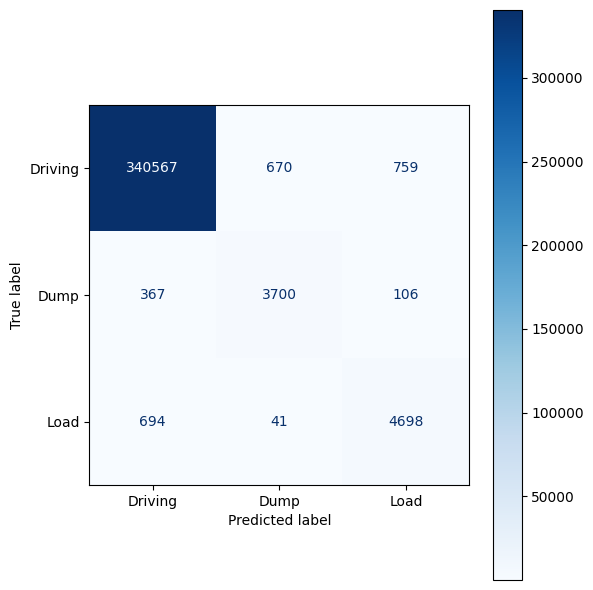

In [24]:
myModel.plot_confusion_matrix()